# Compare SPEI calculation with different PET equations

## Introduction
In the following notebook the calculation of the SPEI with different PET equations is compared to the offical [Global SPEI database](https://spei.csic.es/database.html). The PET equations "FAO 56 Penman-Monteith", "Thornthwaite", "Priestley-Taylor" and "Hargreaves" were used for the calculation.

As input data `.asc` files are used which represent the n-month SPEI in Germany. To calculate this SPEI meteorological data from the [DWD](https://opendata.dwd.de/climate_environment/CDC/) (*Deutscher Wetterdienst*) is used (*see [spei_meteorological.ipynb](../methods/meteorological/spei_meteorological.ipynb) for more details*).

The "log-logistic" distribution has been used for the calculation using all PET equations "FAO 56 Penman-Monteith (FA056PM)", "Thornthwaite (TW)", "Priestley-Taylor (PT)" and "Hargreaves (HG)".

## Implementation

In [2]:
from methods.meteorological.spei_meteorological import read_asc_file
import xarray as xr
import numpy as np
from methods.method1.spei_calc_multi import spatial_subset
from datetime import datetime, timedelta
from config.data_paths import EXT_STORAGE_DIR

Read the `n`-month SPEI `.asc` files calculated by the equations (*FAO-56-PM, TW, PT, HG*).

The variable `n` can be adjusted to `1`, `3`, `6`, `9` or `12` to read the corresponding SPEI files which are located in `methods/meteorological/output`.

In [3]:
n = 1
spei_asc = {}

begin_date = datetime(2022,1,1)
end_date = datetime(2022,11,1)
curr_date = begin_date
equations = ["fao56pm", "tw", "pt", "hg"]
for equation in equations:
    while curr_date <= end_date:
        curr_date_str = curr_date.strftime("%Y%m")
        spei_np, header = read_asc_file(f"../methods/meteorological/output/{n}month/spei_{equation}_ll_{curr_date_str}.asc")
        spei_asc[f"{curr_date_str}-{equation}"] = spei_np

        next_month = curr_date.replace(day=28) + timedelta(days=4)
        curr_date = next_month - timedelta(days=next_month.day - 1)
    curr_date = begin_date


Set the latitude and longitude bounds for the region of Germany and read the official SPEI database's netCDF file
and extract the SPEI values for the region of Germany.

The `.nc` files represents the SPEI values of the whole world from 16th January 1901 to 16th December 2022. The files have been generated by the inventors of the SPEI calculation method.

At [Global SPEI database](https://spei.csic.es/database.html) the `.nc` file can be downloaded.

In [4]:
# Lat and lon bounds for Germany
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

# Open netCDF file
spei_db = xr.open_dataset(f"{EXT_STORAGE_DIR}/drought_data/spei/spei_db/spei_v2-9_19010116_20221216.nc")
spei_db_ger = spatial_subset(spei_db, lat_bounds, lon_bounds)
spei_db_ger

<xarray.Dataset> Size: 2MB
Dimensions:  (lon: 19, lat: 16, time: 1464)
Coordinates:
  * lon      (lon) float64 152B 5.75 6.25 6.75 7.25 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 128B 47.25 47.75 48.25 48.75 ... 53.75 54.25 54.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2022-12-16
Data variables:
    spei     (time, lat, lon) float32 2MB ...
    crs      int32 4B ...
Attributes: (12/15)
    Conventions:  CF-1.8
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    id:           ../outputNcdf/spei01.nc
    summary:      Global dataset of the Standardized Precipitation-Evapotrans...
    keywords:     drought, climatology, SPEI, Standardized Precipitation-Evap...
    ...           ...
    software:     Created in R using the SPEI package (https://cran.r-project...
    call:         spei.nc(sca=i, inPre=../inputData/cru_ts4.07.1901.2022.pre....
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

Load a shape file of Germany to plot the SPEI values to the region of Germany.

In [5]:
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

shape_ger = f"{EXT_STORAGE_DIR}/shape_ger/vg2500_sta.shp"
germany = gpd.read_file(shape_ger)
germany = germany.to_crs('EPSG:4326')

xds = spei_db_ger.rio.write_crs("EPSG:4326")
spei_db_ger_shape = xds.rio.clip(germany.geometry.apply(mapping), germany.crs, drop=True, invert=False)

In [6]:
for var in spei_db_ger_shape.variables:
    if 'grid_mapping' in spei_db_ger_shape[var].attrs:
        del spei_db_ger_shape[var].attrs['grid_mapping']

In [7]:
spei_db_ger_shape["spei"]

<xarray.DataArray 'spei' (time: 1464, lat: 15, lon: 18)> Size: 2MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.18558681,
                 nan,         nan],
        ...,
        [        nan,         nan, -0.2857917 , ..., -0.20788448,
         -0.15176886,         nan],
        [        nan,         nan,         nan, ..., -0.24521767,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.31229413,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.04803436,
                 nan,         nan],
...
        [        nan,         nan, -0.58256215, ..., -1.9322487 ,
         -1.9431359 ,         nan],
        [        nan,         nan,         nan, ..., -2.0667753 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -2.086224  ,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.19749083,
                 nan,         nan],
        ...,
        [        nan,         nan,  0.4825068 , ...,  0.1127845 ,
          0.08029249,         nan],
        [        nan,         nan,         nan, ...,  0.09399618,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.07449882,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 144B 6.25 6.75 7.25 7.75 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 120B 47.75 48.25 48.75 49.25 ... 53.75 54.25 54.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2022-12-16
    crs      int64 8B 0
Attributes:
    units:      1
    long_name:  Standardized Precipitation-Evapotranspiration Index

Extract the min, max and mean values for each month and PET equation.

In [8]:
spei_data = {
    "Month": [],
    "Min SPEI - FAO56PM": [],
    "Min SPEI - TW": [],
    "Min SPEI - PT": [],
    "Min SPEI - HG": [],
    "Min SPEI - SPEI_DB": [],
    "Max SPEI - FAO56PM": [],
    "Max SPEI - TW": [],
    "Max SPEI - PT": [],
    "Max SPEI - HG": [],
    "Max SPEI - SPEI_DB": [],
    "Mean SPEI - FAO56PM": [],
    "Mean SPEI - TW": [],
    "Mean SPEI - PT": [],
    "Mean SPEI - HG": [],
    "Mean SPEI - SPEI_DB": [],
}

In [9]:
curr_date = begin_date
for equation in equations:
    while curr_date <= end_date:
        curr_date_str = curr_date.strftime("%Y%m")
        
        if not curr_date.strftime("%Y-%m") in spei_data["Month"]:
            spei_data["Month"].append(curr_date.strftime("%Y-%m"))
        spei_asc_equation = spei_asc[f"{curr_date_str}-{equation}"]
        spei_data[f"Min SPEI - {equation.upper()}"].append(np.nanmin(spei_asc_equation))
        spei_data[f"Max SPEI - {equation.upper()}"].append(np.nanmax(spei_asc_equation))
        spei_data[f"Mean SPEI - {equation.upper()}"].append(np.nanmean(spei_asc_equation))

        next_month = curr_date.replace(day=28) + timedelta(days=4)
        curr_date = next_month - timedelta(days=next_month.day - 1)
    curr_date = begin_date

In [10]:
while curr_date <= end_date:
    print(curr_date)
    curr_date_str = curr_date.strftime("%Y%m")

    spei_netcdf_np = spei_db_ger_shape["spei"].sel(time=slice(f"{curr_date.strftime('%Y-%m')}-01", f"{curr_date.strftime('%Y-%m')}-28"))
    spei_data["Min SPEI - SPEI_DB"].append(np.nanmin(spei_netcdf_np.values))
    spei_data["Max SPEI - SPEI_DB"].append(np.nanmax(spei_netcdf_np.values))
    spei_data["Mean SPEI - SPEI_DB"].append(np.nanmean(spei_netcdf_np.values))

    next_month = curr_date.replace(day=28) + timedelta(days=4)
    curr_date = next_month - timedelta(days=next_month.day - 1)

2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00


In [11]:
spei_data

{'Month': ['2022-01',
  '2022-02',
  '2022-03',
  '2022-04',
  '2022-05',
  '2022-06',
  '2022-07',
  '2022-08',
  '2022-09',
  '2022-10',
  '2022-11'],
 'Min SPEI - FAO56PM': [-3.8007,
  -2.4907,
  -2.3791,
  -2.896,
  -3.6741,
  -2.2118,
  -2.608,
  -2.4262,
  -2.9697,
  -2.338,
  -2.3037],
 'Min SPEI - TW': [-4.4906,
  -10.1343,
  -7.6537,
  -14.8085,
  -3.6177,
  -2.3685,
  -2.5422,
  -2.1596,
  -3.0961,
  -2.4824,
  -20.5816],
 'Min SPEI - PT': [-2.7523,
  -2.3044,
  -2.5518,
  -3.9518,
  -3.1648,
  -2.6915,
  -2.1881,
  -3.438,
  -3.246,
  -2.8586,
  -3.2408],
 'Min SPEI - HG': [-3.6538,
  -2.6386,
  -1.6496,
  -3.1768,
  -3.3776,
  -2.3734,
  -2.6035,
  -1.9329,
  -3.0924,
  -2.4806,
  -2.3933],
 'Min SPEI - SPEI_DB': [-1.3099864,
  -0.79512864,
  -2.8354368,
  -0.89830106,
  -1.9662479,
  -2.4811935,
  -2.1054492,
  -2.316696,
  -0.122050665,
  -1.5321984,
  -2.090944],
 'Max SPEI - FAO56PM': [3.921,
  7.2692,
  3.2264,
  3.9096,
  5.3479,
  4.8418,
  4.0289,
  4.0261,
  4.2569

Create the minimum monthly `n`-month SPEI values for each PET equation and compare them to the official SPEI values.

In [12]:
import pandas as pd

spei_df = pd.DataFrame(spei_data)
spei_df['Month'] = pd.to_datetime(spei_df['Month'])

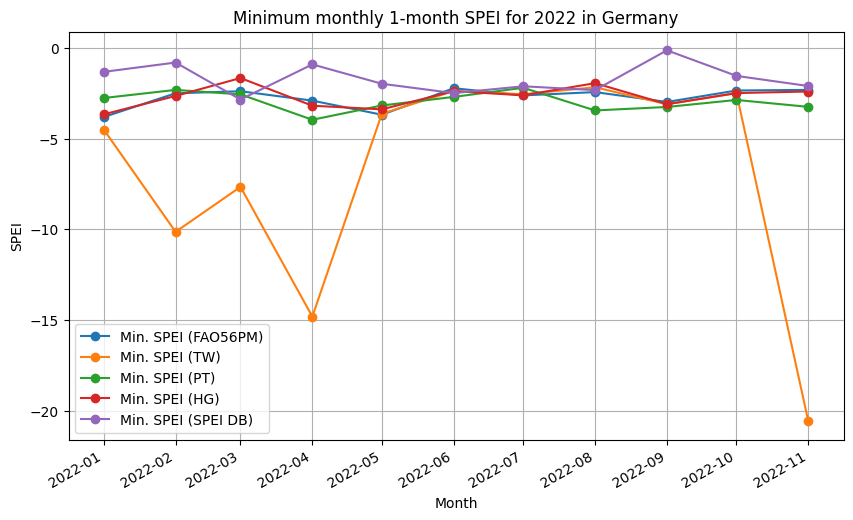

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot each temperature metric
for equation in equations:
    plt.plot(spei_df['Month'], spei_df[f'Min SPEI - {equation.upper()}'], label=f'Min. SPEI ({equation.upper()})', marker='o')

plt.plot(spei_df['Month'], spei_df[f'Min SPEI - SPEI_DB'], label=f'Min. SPEI (SPEI DB)', marker='o')

# Formatting the plot
plt.title('Minimum monthly 1-month SPEI for 2022 in Germany')
plt.xlabel('Month')
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

# Improve the x-axis to show each month more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels to prevent overlap

plt.show()

Create the maximum monthly `n`-month SPEI values for each PET equation and compare them to the official SPEI values.

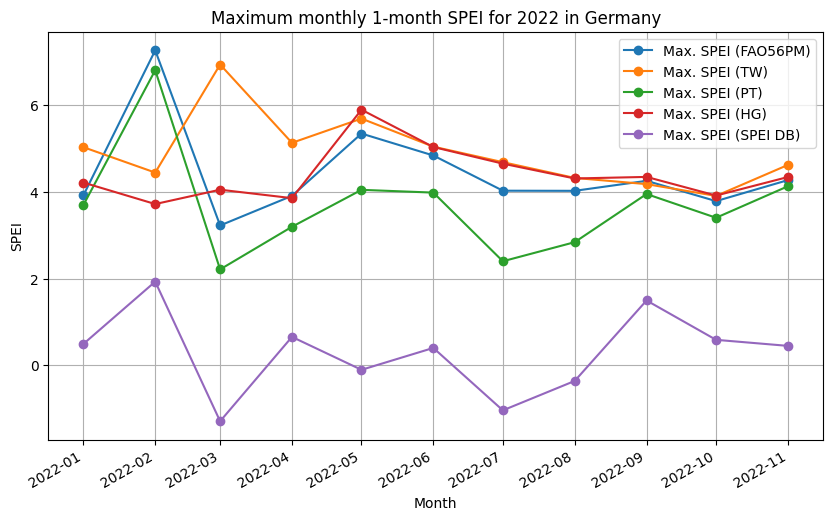

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot each temperature metric
for equation in equations:
    plt.plot(spei_df['Month'], spei_df[f'Max SPEI - {equation.upper()}'], label=f'Max. SPEI ({equation.upper()})', marker='o')

plt.plot(spei_df['Month'], spei_df[f'Max SPEI - SPEI_DB'], label=f'Max. SPEI (SPEI DB)', marker='o')

# Formatting the plot
plt.title('Maximum monthly 1-month SPEI for 2022 in Germany')
plt.xlabel('Month')
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

# Improve the x-axis to show each month more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels to prevent overlap

plt.show()


Create the mean monthly `n`-month SPEI values for each PET equation and compare them to the official SPEI values.

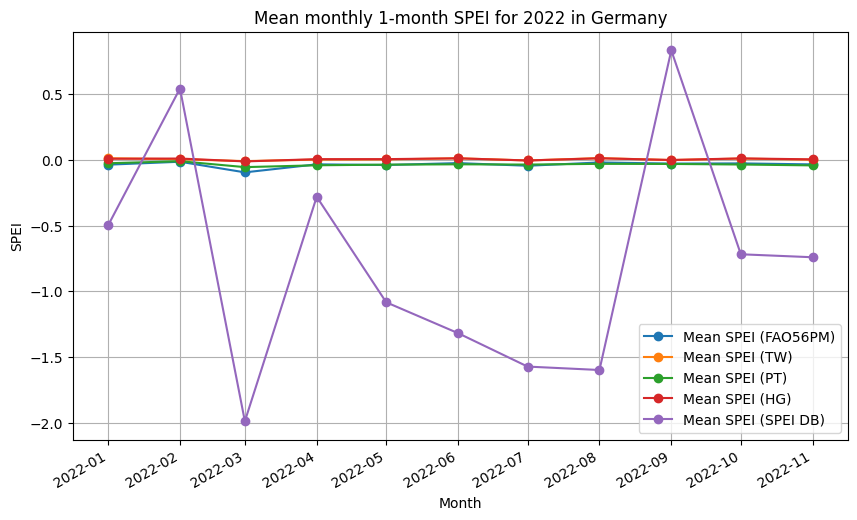

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the plot size
plt.figure(figsize=(10, 6))

# Plot each temperature metric
for equation in equations:
    plt.plot(spei_df['Month'], spei_df[f'Mean SPEI - {equation.upper()}'], label=f'Mean SPEI ({equation.upper()})', marker='o')

plt.plot(spei_df['Month'], spei_df[f'Mean SPEI - SPEI_DB'], label=f'Mean SPEI (SPEI DB)', marker='o')

# Formatting the plot
plt.title('Mean monthly 1-month SPEI for 2022 in Germany')
plt.xlabel('Month')
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

# Improve the x-axis to show each month more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels to prevent overlap

plt.show()


In [16]:
spei_df

,Month,Min SPEI - FAO56PM,Min SPEI - TW,Min SPEI - PT,Min SPEI - HG,Min SPEI - SPEI_DB,Max SPEI - FAO56PM,Max SPEI - TW,Max SPEI - PT,Max SPEI - HG,Max SPEI - SPEI_DB,Mean SPEI - FAO56PM,Mean SPEI - TW,Mean SPEI - PT,Mean SPEI - HG,Mean SPEI - SPEI_DB
0,2022-01-01,-3.8007,-4.4906,-2.7523,-3.6538,-1.309986,3.9210,5.0335,3.6967,4.2167,0.490700,-0.035477,0.013585,-0.024698,0.009594,-0.497564
1,2022-02-01,-2.4907,-10.1343,-2.3044,-2.6386,-0.795129,7.2692,4.4472,6.8099,3.7207,1.930228,-0.013152,0.005991,-0.009086,0.011303,0.544446
2,2022-03-01,-2.3791,-7.6537,-2.5518,-1.6496,-2.835437,3.2264,6.9415,2.2123,4.0519,-1.292753,-0.094012,-0.008464,-0.054108,-0.010637,-1.988921
3,2022-04-01,-2.8960,-14.8085,-3.9518,-3.1768,-0.898301,3.9096,5.1339,3.1959,3.8570,0.654359,-0.032910,0.003167,-0.040095,0.006605,-0.279821
4,2022-05-01,-3.6741,-3.6177,-3.1648,-3.3776,-1.966248,5.3479,5.6934,4.0489,5.8988,-0.105669,-0.037860,0.004304,-0.035227,0.006737,-1.083340
5,2022-06-01,-2.2118,-2.3685,-2.6915,-2.3734,-2.481194,4.8418,5.0456,3.9850,5.0371,0.399428,-0.023410,0.013150,-0.032701,0.012940,-1.318367
6,2022-07-01,-2.6080,-2.5422,-2.1881,-2.6035,-2.105449,4.0289,4.6876,2.4002,4.6534,-1.041424,-0.043679,-0.003476,-0.034623,-0.003430,-1.572776
7,2022-08-01,-2.4262,-2.1596,-3.4380,-1.9329,-2.316696,4.0261,4.3237,2.8408,4.3112,-0.362587,-0.018687,0.014494,-0.029150,0.013293,-1.598771
8,2022-09-01,-2.9697,-3.0961,-3.2460,-3.0924,-0.122051,4.2569,4.1808,3.9522,4.3472,1.495043,-0.027074,-0.000294,-0.029911,0.000184,0.835164
9,2022-10-01,-2.3380,-2.4824,-2.8586,-2.4806,-1.532198,3.7888,3.9089,3.4042,3.9167,0.586420,-0.025714,0.011173,-0.034260,0.012350,-0.717664


## Percentages
Shows the percentage of the calculated SPEI values that are:
- above the value `+1.0` (*wet*)
- between or equal the value `-1.0` and `+1.0` (*normal*)
- below the value `-1.0` (*dry*)
  

In [17]:
equations.append("SPEI_DB")

In [47]:
curr_date = begin_date
perc_results = {}
perc_results_sum = {}
for equation in equations:
    while curr_date <= end_date:
        if equation.upper() == "SPEI_DB":
            values = spei_db_ger_shape["spei"].sel(time=slice(
                f"{curr_date.strftime('%Y-%m')}-01", f"{curr_date.strftime('%Y-%m')}-28")).values
        else:
            values = spei_asc[f"{curr_date_str}-{equation.lower()}"]

        curr_date_str = curr_date.strftime("%Y%m")

        # if not curr_date.strftime("%Y-%m") in spei_data["Month"]:
        #     spei_data["Month"].append(curr_date.strftime("%Y-%m"))

        perc_over_plus1 = (values > 1.0).mean() * 100
        perc_below_minus1 = (values < -1.0).mean() * 100
        perc_ok = (spei_df[f'Min SPEI - {equation.upper()}'].between(-1.0, 1.0)).mean()

        if not curr_date_str in perc_results:
            perc_results[curr_date_str] = {}

        perc_results[curr_date_str][equation.upper()] = {
            "perc_below_1": perc_below_minus1,
            "perc_ok": perc_ok,
            "perc_over_1": perc_over_plus1
        }

        perc_results[curr_date_str][equation.upper()] = {
            "perc_below_1": perc_below_minus1,
            "perc_ok": perc_ok,
            "perc_over_1": perc_over_plus1
        }

        if not equation.upper() in perc_results_sum:
            perc_results_sum[equation.upper()] = {}

        if (not "perc_below_1" in perc_results_sum[equation.upper()]) or \
            (not "perc_ok" in perc_results_sum[equation.upper()]) or \
                (not "perc_over_1" in perc_results_sum[equation.upper()]):
            perc_results_sum[equation.upper()] = {
                "perc_below_1": perc_below_minus1,
                "perc_ok": perc_ok,
                "perc_over_1": perc_over_plus1
            }
        else:
            perc_results_sum[equation.upper()]["perc_below_1"] += perc_below_minus1
            perc_results_sum[equation.upper()]["perc_ok"] += perc_ok
            perc_results_sum[equation.upper()]["perc_over_1"] += perc_over_plus1

        next_month = curr_date.replace(day=28) + timedelta(days=4)
        curr_date = next_month - timedelta(days=next_month.day - 1)
    curr_date = begin_date

In [48]:
from dateutil.relativedelta import relativedelta

difference = relativedelta(end_date, begin_date)
total_months = difference.years * 12 + difference.months
print(total_months)
for equation in equations:
    perc_results_sum[equation.upper()]["perc_below_1"] = perc_results_sum[equation.upper()]["perc_below_1"] / total_months
    perc_results_sum[equation.upper()]["perc_over_1"] = perc_results_sum[equation.upper()]["perc_over_1"] / total_months
    perc_results_sum[equation.upper()]["perc_ok"] = 100 - perc_results_sum[equation.upper()]["perc_over_1"] - perc_results_sum[equation.upper()]["perc_below_1"]

10


In [49]:
perc_results_sum

{'FAO56PM': {'perc_below_1': 11.934868741657308,
  'perc_ok': 78.0933286720201,
  'perc_over_1': 9.971802586322577},
 'TW': {'perc_below_1': 12.193995381062354,
  'perc_ok': 76.57617715815272,
  'perc_over_1': 11.229827460784936},
 'PT': {'perc_below_1': 11.107432675805665,
  'perc_ok': 79.59420090259974,
  'perc_over_1': 9.298366421594592},
 'HG': {'perc_below_1': 12.50291332076191,
  'perc_ok': 75.64121307145228,
  'perc_over_1': 11.855873607785806},
 'SPEI_DB': {'perc_below_1': 37.85185185185185,
  'perc_ok': 56.96296296296296,
  'perc_over_1': 5.185185185185185}}

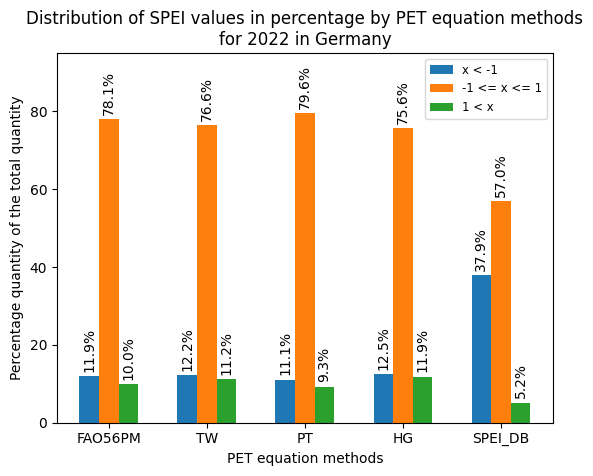

In [50]:
import matplotlib.pyplot as plt

methods = list(perc_results_sum.keys())
perc_below_1 = [perc_results_sum[method]['perc_below_1'] for method in methods]
perc_ok = [perc_results_sum[method]['perc_ok'] for method in methods]
perc_over_1 = [perc_results_sum[method]['perc_over_1'] for method in methods]

x = range(len(methods))
bar_width = 0.2

r1 = range(len(equations))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, ax = plt.subplots()
rects1 = ax.bar(r1, perc_below_1, bar_width, label='x < -1')
rects2 = ax.bar(r2, perc_ok, bar_width, label='-1 <= x <= 1')
rects3 = ax.bar(r3, perc_over_1, bar_width, label='1 < x')

# Add percentage text above each bar
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', rotation='vertical')
for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', rotation='vertical')
for rect in rects3:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", rotation='vertical',
                ha='center', va='bottom')

plt.ylim(0, 95)
ax.set_xlabel('PET equation methods')
ax.set_ylabel('Percentage quantity of the total quantity')
ax.set_title('Distribution of SPEI values in percentage by PET equation methods\nfor 2022 in Germany')
ax.set_xticks([i + bar_width for i in x])
ax.set_xticklabels(methods)
ax.legend(fontsize='small')

plt.show()